# introduction to ATL11
This notebook uses standard python tools to demonstrate some basic usage of the ATL11 product.  To run the examples here, you'll need to grab a directory of ATL11 files from Google Drive, and specify the directory where you've put them in the next cell.

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
%load_ext autoreload
%autoreload 2
# put your ATL11 directory here:
ATL11_dir='/Volumes/ice2/ben/scf/GL_11/U05/'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
thefile=glob.glob(os.path.join(ATL11_dir, 'ATL11_059703*.h5'))[0]

with h5py.File(thefile,'r') as h5f:
    print(h5f.keys())

<KeysViewHDF5 ['METADATA', 'index', 'pt1', 'pt2', 'pt3']>


In each pair-track group, there are four groups:

In [217]:
with h5py.File(thefile,'r') as h5f:
    print(h5f['pt1'].keys())

<KeysViewHDF5 ['corrected_h', 'crossing_track_data', 'cycle_stats', 'ref_surf']>


The second-level groups are:

**corrected_h**: elevation data corrected for local surface-elevation shape.  Organized by reference point (first dimension) and cycle (second dimension)
**cycle_stats**: parameters describing the data characteristics for each cycle.  Organized by reference point (first dimension) and cycle (second dimension)
**ref_surf**: Parameters describing the reference-surface fit.  First dimension is reference points, second dimension (if present) gives the polynomial coefficients
**crossing_track_data**: crossover data.  Each value gives a corrected value for a crossing track.  Use the reference_point and latitude/longitude fields to locate and reference the data.

## reading and filtering data
Let's read some data, and some groups that will help interpret it:

In [218]:
with h5py.File(thefile,'r') as h5f:
    # select pair track1
    p1=h5f['pt1']
    # read in the along-track coordinates
    x_atc=np.array(p1['ref_surf']['x_atc'])
    
    # read in the along-track coordinates
    ref_pt=np.array(p1['corrected_h']['ref_pt'])
    
    # read in the corrected_h
    h_corr=np.array(p1['corrected_h']['h_corr'])
    # mask out invalid values
    bad=(h_corr==p1['corrected_h']['h_corr'].attrs['_FillValue'])
    h_corr[bad]=np.NaN
    
    # error
    h_corr_sigma=np.array(p1['corrected_h']['h_corr_sigma'])
    bad=(h_corr_sigma==p1['corrected_h']['h_corr_sigma'].attrs['_FillValue'])
    h_corr_sigma[bad]=np.NaN
    
    # systematic error
    h_corr_sigma_s=np.array(p1['corrected_h']['h_corr_sigma_systematic'])
    bad=(h_corr_sigma==p1['corrected_h']['h_corr_sigma_systematic'].attrs['_FillValue'])
    h_corr_sigma_s[bad]=np.NaN
    
    # N slope
    n_slope=np.array(p1['ref_surf']['n_slope'])
    e_slope=np.array(p1['ref_surf']['e_slope'])
    bad = (n_slope==p1['ref_surf']['n_slope'].attrs['_FillValue'])
    bad |= (e_slope==p1['ref_surf']['e_slope'].attrs['_FillValue'])
    n_slope[bad]=np.NaN
    e_slope[bad]=np.NaN
    slope_mag=np.sqrt(n_slope**2+e_slope**2)
    
     # get the ATL06-based quality summary
    h_quality_summary = np.array(p1['corrected_h']['quality_summary'])
    
    # get the reference-surface quality summary
    r_quality_summary = np.array(p1['ref_surf']['quality_summary'])
    
    # read the cycle_number
    cycle_num=np.array(p1['corrected_h']['cycle_number'])
    

First, let's plot the surface height as a function of along-track distance.  Each column of the h_corr variable gives an elevation from a different cycle, and we'll plot them in different colors

Text(0, 0.5, 'number of cycles present')

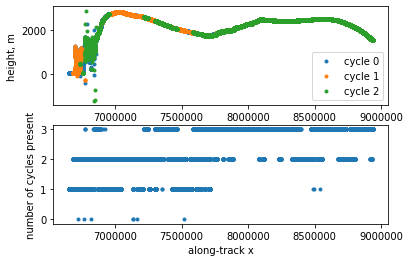

In [219]:
plt.figure()
plt.subplot(211)
for cycle in range(0, h_corr.shape[1]):
    plt.plot(x_atc, h_corr[:, cycle],'.', label=f"cycle {cycle}")
plt.legend()
plt.xlabel('along-track distance')
plt.ylabel('height, m')

plt.subplot(212)
plt.plot(x_atc, np.sum(np.isfinite(h_corr), axis=1),'.')
plt.xlabel('along-track x')
plt.ylabel('number of cycles present')

It looks like there's some bad scatter on the right-hand side of the plot.  Let's see if we can filter it out using ATL11 parameters.  

We'll be filtering elevations based on parameters that apply to entire reference points, so we'll need to make replicated copies of some fields.

In [220]:
x_rep=np.tile(x_atc[:, np.newaxis],[1, 3])
q_rep=np.tile(r_quality_summary[:, np.newaxis],[1, 3])


A scatter plot of the fit quality vs. along-track distance shows a lot of flagged points in the messy region:

(6750000.0, 6870000.0)

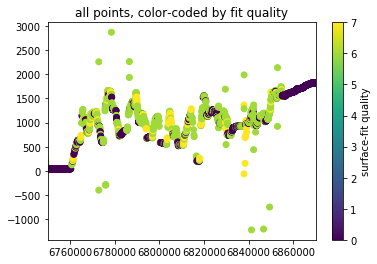

In [221]:
fig=plt.figure(3); plt.clf(); 
hs=plt.scatter(x_rep.ravel(), h_corr.ravel(), c=q_rep.ravel()); 
hb=plt.colorbar(hs)
hb.set_label('surface-fit quality')
plt.title('all points, color-coded by fit quality')
plt.gca().set_xlim([6.75e6, 6.87e6])

It looks like the worst points have large values of surface-fit quality *ptx/ref_surf/quality_summary*:

Text(0, 0.5, 'reference-surface quality summary')

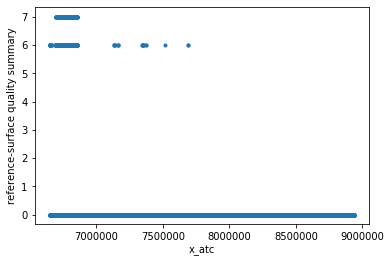

In [222]:
plt.figure(); 
plt.plot(x_atc, r_quality_summary,'.')
plt.xlabel('x_atc')
plt.ylabel('reference-surface quality summary')

values of *6* indicate polynomial coefficients with large errors

values of *7* indicate large surface slopes.  

Let's see if filtering out the quality_summary == 6 points removes the scatter, and if the ATL06_quality flag helps decrease the scatter

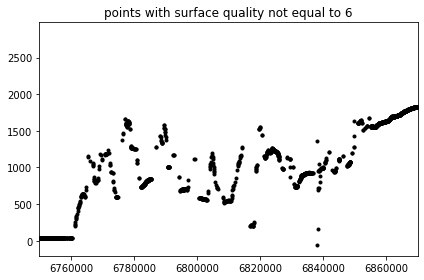

In [226]:
fig=plt.figure(2); plt.clf()
plt.plot(x_rep.ravel()[q_rep.ravel() != 6], h_corr.ravel()[q_rep.ravel() != 6],'k.')
plt.title('points with surface quality not equal to 6')
plt.gca().set_xlim([6.75e6, 6.87e6])
plt.tight_layout()
#plt.show()



This is clearly an improvement from the previous plot of the same region: the scattered points have mostly disappeared, because we have removed the points corrected with reference surfaces that have large polynomial errors.  Let's use this to generate dh plots for the whole segment:

/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square


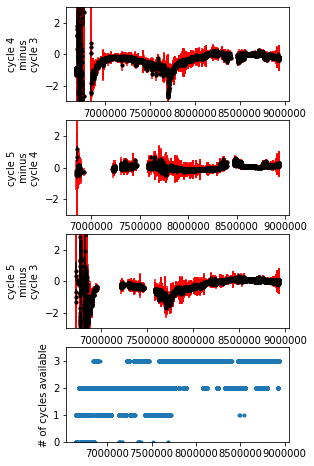

In [224]:
plt.figure(3, figsize=[4,8]); plt.clf()
ax=[]
good=np.flatnonzero(q_rep[:,0] !=6)
# cycle-to-cycle elevation differences
for col in [1, 2]:
    ax += [plt.subplot(4, 1, col)]
    this_dh=h_corr[good,col]-h_corr[good,col-1]
    # cycle-to-cycle difference errors are the quadratic sums of the cycle errors
    this_dh_sigma=np.sqrt(h_corr_sigma[good,col]**2+h_corr_sigma[good,col-1]**2)
    # Likewise for systematic errors:
    this_dh_sigma_s = np.sqrt(h_corr_sigma_s[good,col]**2+h_corr_sigma_s[good,col-1]**2)
    plt.errorbar(x_rep[good,col].ravel(), this_dh, yerr=np.sqrt(this_dh_sigma**2+this_dh_sigma_s**2), fmt='r.')
    plt.errorbar(x_rep[good,col].ravel(), this_dh, yerr=this_dh_sigma, fmt='k.')

# cycle 5 minus cycle 3 differences:
ax += [plt.subplot(4, 1, 3)]
this_dh=h_corr[good,2]-h_corr[good,0]
this_dh_sigma=np.sqrt(h_corr_sigma[good,2]**2+h_corr_sigma[good,0]**2)
this_dh_sigma_s = np.sqrt(h_corr_sigma_s[good,2]**2+h_corr_sigma_s[good,0]**2)
plt.errorbar(x_rep[good,col].ravel(), this_dh, yerr=np.sqrt(this_dh_sigma**2+this_dh_sigma_s**2), fmt='r.')
plt.errorbar(x_rep[good,col].ravel(), this_dh, yerr=this_dh_sigma, fmt='k.')
# plot of the number of cycles available:
ax += [plt.subplot(4, 1, 4)]
plt.plot(x_atc, np.sum(np.isfinite(h_corr)& (q_rep !=6), axis=1),'.')

# label axes
ax[0].set_ylabel(f'cycle {cycle_num[1]}\n minus \ncycle {cycle_num[0]}')
ax[1].set_ylabel(f'cycle {cycle_num[2]}\n minus \ncycle {cycle_num[1]}')
ax[2].set_ylabel(f'cycle {cycle_num[2]}\n minus \ncycle {cycle_num[0]}')
ax[3].set_ylabel('# of cycles available')
for axi in ax[0:3]:
    axi.set_ylim([-3, 3])

ax[3].set_ylim([0, 3.5]);


Coverage is fairly continuous for cycle 3, but more partial for cycles 4 and 5.
Cycle-to-cycle differences show the substantial drawdown over the summer of 2019 (between cycles 3 and 4), followed by a weak, partial recovery in the fall of 2019 (between cycles 4 and 5).  The net result (cycles 3-5) is mass loss. 

Uncorrelated error estimates are on the centimeter scale, but the product of geolocation errors (estimated at 20 m for relase 002) and surface slope gives decimeter-scale systematic error estimates for most parts of the granule. 

The large scatter at the left-hand side of the plot is reflected in large error estimates.


## mapping dh/dt for the ice sheet

Now that we have a handle on how to read data and eliminate the worst glitches, let's make a function to read ATL11 data and turn it loose over all of Greenland

In [179]:
# data-reading function
import pyproj

# generic field-reading function:
def read_field(group, field):
    data=np.array(group[field])
    bad=(data==group[field].attrs['_FillValue'])
    data[bad]=np.NaN
    return data

def read_ATL11(filename, pair):
    with h5py.File(filename,'r') as h5f:
        latitude=read_field(h5f[pair]['corrected_h'],'latitude')
        longitude=read_field(h5f[pair]['corrected_h'],'longitude')
        h_corr=read_field(h5f[pair]['corrected_h'],'h_corr')
        h_corr_sigma=read_field(h5f[pair]['corrected_h'],'h_corr_sigma')
        h_corr_sigma_s=read_field(h5f[pair]['corrected_h'],'h_corr_sigma_systematic')
        quality=np.array(h5f[pair]['ref_surf']['quality_summary'])
    for col in range(h_corr.shape[1]):
        h_corr[quality==6]=np.NaN
    xy=np.array(pyproj.Proj("+init=epsg:3413")(longitude, latitude))
    return xy[0,:].ravel(), xy[1,:].ravel(), h_corr, np.sqrt(h_corr**2+h_corr_sigma**2)

In [161]:
import glob
import os
ATL11_dir="/Volumes/ice2/ben/scf/GL_11/U05/"
files=glob.glob(os.path.join(ATL11_dir, 'ATL11*.h5'))

x=[]
y=[]
h_corr=[]
sigma_h=[]
for file in files:
    try:
        for pair in ['pt1','pt2','pt3']:
            xx, yy, hh, ss=read_ATL11(file, pair)
            x += [xx]
            y += [yy]
            h_corr += [hh]
            sigma_h += [ss]
    except Exception as E:
        pass
x=np.concatenate(x)
y=np.concatenate(y)
h_corr=np.concatenate(h_corr, axis=0)
sigma_h=np.concatenate(sigma_h, axis=0)

(-3500000.0, -700000.0)

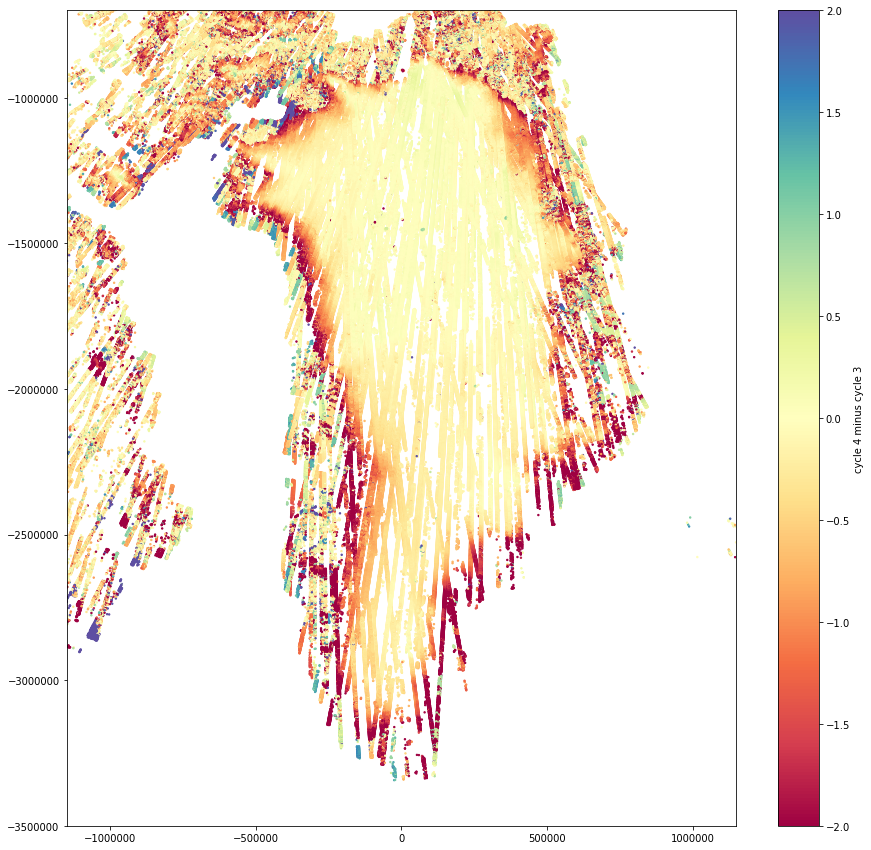

In [181]:
plt.figure(figsize=[15, 15])
plt.scatter(x[::20], y[::20], 2,  c=h_corr[::20,1]-h_corr[::20,0], vmin=-2, vmax=2, cmap='Spectral')
plt.axis('equal');
hb=plt.colorbar(); hb.set_label('cycle 4 minus cycle 3')

plt.gca().set_xlim([-1.e6, 1.e6]);
plt.gca().set_ylim([-3.5e6, -0.7e6]);


(-3500000.0, -700000.0)

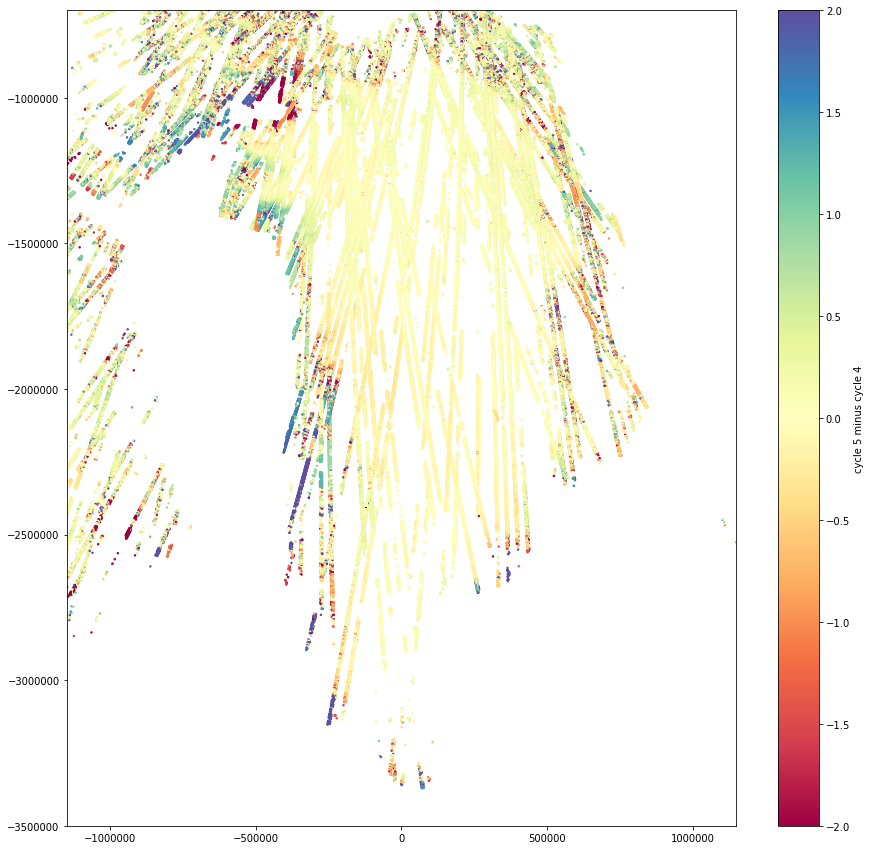

In [182]:
plt.figure(figsize=[15, 15])

plt.scatter(x[::20], y[::20],  2, c=h_corr[::20,2]-h_corr[::20,1], vmin=-2, vmax=2, cmap='Spectral')
plt.axis('equal');
hb=plt.colorbar(); 
hb.set_label('cycle 5 minus cycle 4')
plt.gca().set_xlim([-1.e6, 1.e6]);
plt.gca().set_ylim([-3.5e6, -0.7e6]);



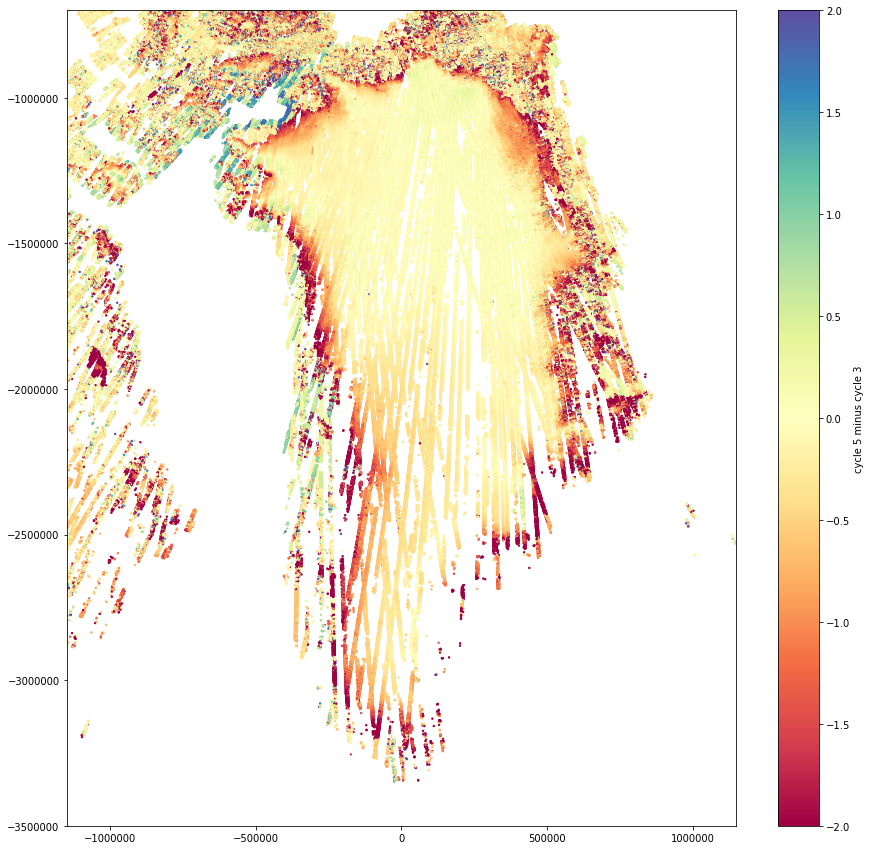

In [183]:
plt.figure(figsize=[15, 15])

plt.scatter(x[::20], y[::20],  2, c=h_corr[::20,2]-h_corr[::20,0], vmin=-2, vmax=2, cmap='Spectral')
plt.axis('equal');
hb=plt.colorbar(); 
hb.set_label('cycle 5 minus cycle 3')
plt.gca().set_xlim([-1.e6, 1.e6]);
plt.gca().set_ylim([-3.5e6, -0.7e6]);